/tmp/ipykernel_35379/3748606120.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


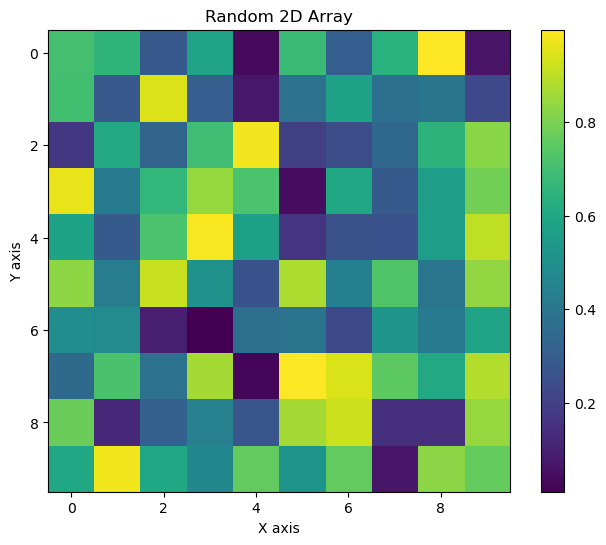

In [1]:
import sys
import os
import argparse
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

import modules.spikingjelly;
from modules.spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from modules.spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from modules.spikingjelly.datasets.n_mnist import NMNIST
# from modules.spikingjelly.datasets.es_imagenet import ESImageNet
from modules.spikingjelly.datasets import split_to_train_test_set
from modules.spikingjelly.datasets.n_caltech101 import NCaltech101
from modules.spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import modules.torchneuromorphic as torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz
from turtle import shape



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [3]:
seed_assign(42)

In [4]:

# def fire_function(gamma):
#     class ZIF(torch.autograd.Function): # zero is firing
#         @staticmethod
#         def forward(ctx, input):
#             out = (input >= 0).float()
#             ctx.save_for_backward(input)
#             return out


#         # 걍 근데 이건 1/2보다 작으면 1
#         # 1/2보다 크면 0인데?
#         @staticmethod
#         def backward(ctx, grad_output):
#             (input, ) = ctx.saved_tensors
#             grad_input = grad_output.clone()
#             tmp = (input.abs() < gamma/2).float() / gamma
#             grad_input = grad_input * tmp
#             return grad_input, None

#     return ZIF.apply


# class LIFSpike(nn.Module):
#     def __init__(self, thresh=0.5, tau=0.25, gamma=4.0):
#         super(LIFSpike, self).__init__()
#         self.thresh = thresh
#         self.tau = tau
#         self.gamma = gamma

#     def forward(self, x):
#         mem = torch.zeros_like(x[0])

#         spikes = []
#         T = x.shape[0]
#         for t in range(T):
#             mem = mem.detach() * self.tau + x[t] #걍 인덱스별로 각각 덧셈
#             # mem = mem * self.tau + x[t] #걍 인덱스별로 각각 덧셈
#             spike = fire_function(self.gamma)(mem - self.thresh)
#             # mem = (1 - spike.detach()) * mem #spike나감과 동시에 reset
#             mem = mem - spike.detach() * self.thresh
#             spikes.append(spike)

        
#         return torch.stack(spikes, dim=0)

In [5]:
# for kkk in range(4):
#     if kkk == 0:
#         v_reset = 0.0
#         BPTT_on = True
#     elif kkk == 1:
#         v_reset = 0.0
#         BPTT_on = False

#     elif kkk == 2:
#         v_reset = 10000.0
#         BPTT_on = True
#     elif kkk == 3:
#         v_reset = 10000.0
#         BPTT_on = False

#     print('\n\n\n',v_reset, BPTT_on, '\n\n\n')

#     hyper_run_time = 10
#     goat_val_acc = 0
#     for iii in range(hyper_run_time):
#         print(f"\nHyper Run Time : {iii+1}/{hyper_run_time}\n\n")

#         # 1. 하이퍼파라미터 설정
#         batch_size = 32
#         num_epochs = 10
#         learning_rate = 0.00001
#         num_steps = 10  # SNN에서 사용할 time step

#         v_init = 0.0
#         v_decay = 0.5
#         v_threshold = 1.0
#         v_reset = v_reset
#         sg_width = 4.0
#         # surrogate = 'sigmoid'
#         surrogate = 'rectangle'
#         BPTT_on = BPTT_on # True False

#         # 2. 데이터셋 로드 (MNIST)
#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.1307,), (0.3081,))
#         ])

#         train_dataset = datasets.MNIST(root="/data2", train=True, download=True, transform=transform)
#         test_dataset = datasets.MNIST(root="/data2", train=False, download=True, transform=transform)

#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




#         # 3. SNN 모델 정의
#         class SNN(nn.Module):
#             def __init__(self, v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on):
#                 super().__init__()
#                 self.fc1 = nn.Linear(28 * 28, 200)  # 출력 크기를 10으로 변경
#                 self.lif1 = LIF_layer(v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on)
#                 # self.lif1 = LIFSpike(thresh = v_threshold, tau = v_decay, gamma = sg_width)
                
#                 self.fc2 = nn.Linear(200, 10)  # 출력 크기를 10으로 변경

#             def forward(self, x):
#                 # x : T B C H W
#                 # print(x.shape)
#                 T = x.size(0)
#                 B = x.size(1)
#                 x = x.view(x.size(0), x.size(1), -1) # T B HW
#                 # print(x.shape)
#                 x = x.view(T*B, -1)# TB HW
#                 # print(x.shape)
#                 x = self.fc1(x)
#                 # print(x.shape)
#                 x = x.view(T, B, -1)
#                 # print(x.shape)
#                 x = self.lif1(x)
#                 x = x.view(T*B, -1)# TB HW
#                 x = self.fc2(x)
#                 x = x.view(T, B, -1)
#                 # 0차원 mean
#                 # print(x.shape)
#                 # x = x.mean(dim=0) # B 10
#                 # print(x.shape)
#                 # print(x[0])
#                 return x

#         # 4. 모델 초기화
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         model = SNN(v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on).to(device)
#         criterion = nn.CrossEntropyLoss().to(device)
#         criterion_count = SF.ce_count_loss()  # 손실 함수
#         # sgd optimizer
#         optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#         # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#         print(model)

#         # 6. 모델 평가
#         def test(model, test_loader):
#             model.eval()
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 for images, labels in test_loader:
#                     images, labels = images.to(device), labels.to(device)
#                     images = images.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1)
#                     spk_out = model(images)
#                     spk_out = spk_out.mean(dim=0) # B 10
#                     pred = spk_out.argmax(dim=1) 
#                     correct += (pred == labels).sum().item()
#                     total += labels.size(0)

#             return correct / total

#         # 5. 모델 학습
#         print("Training Start...")
#         best_val_acc = 0
#         for epoch in range(num_epochs):
#             train_loss = 0
#             for images, labels in train_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 # images : B C H W

#                 images = images.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1)
#                 # images : T B C H W

#                 spk_out = model(images)

#                 # loss = criterion_count(spk_out, labels)
#                 spk_out = spk_out.sum(dim=0) # B 10
#                 loss = criterion(spk_out, labels)

#                 pred = spk_out.argmax(dim=1)
                
#                 loss.backward()
#                 optimizer.step()
                
#                 correct = (pred == labels).sum().item()
#                 total = labels.size(0)
#                 acc = correct / total

#                 train_loss += loss.item()
#             val_acc = test(model, test_loader)
#             best_val_acc = max(best_val_acc, val_acc)
#             goat_val_acc = max(goat_val_acc, val_acc)
#             print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.8f}, tr_acc: {acc*100:.2f}%, val_acc: {val_acc*100:.2f}%, best_acc: {best_val_acc*100:.2f}%, goat_acc: {goat_val_acc*100:.2f}%, v_reset: {v_reset}, BPTT_on: {BPTT_on}")




In [6]:
for kkk in range(4):
    if kkk == 0:
        v_reset = 0.0
        BPTT_on = True
    elif kkk == 1:
        v_reset = 0.0
        BPTT_on = False

    elif kkk == 2:
        v_reset = 10000.0
        BPTT_on = True
    elif kkk == 3:
        v_reset = 10000.0
        BPTT_on = False

    print('\n\n\n',v_reset, BPTT_on, '\n\n\n')

    hyper_run_time = 10
    goat_val_acc = 0
    for iii in range(hyper_run_time):
        print(f"\nHyper Run Time : {iii+1}/{hyper_run_time}\n\n")

        # 1. 하이퍼파라미터 설정
        batch_size = 32
        num_epochs = 10
        learning_rate = 0.001
        num_steps = 10  # SNN에서 사용할 time step

        v_init = 0.0
        v_decay = 0.5
        v_threshold = 1.0
        v_reset = v_reset
        sg_width = 4.0
        # surrogate = 'sigmoid'
        surrogate = 'rectangle'
        BPTT_on = BPTT_on # True False

        # 2. 데이터셋 로드 (MNIST)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))
        ])

        train_dataset = datasets.MNIST(root="/data2", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="/data2", train=False, download=True, transform=transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




        # 3. SNN 모델 정의
        class SNN(nn.Module):
            def __init__(self, v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on):
                super().__init__()
                self.fc1 = nn.Linear(28 * 28, 1000)  # 출력 크기를 10으로 변경
                self.lif1 = LIF_layer(v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on)
                # self.lif1 = LIFSpike(thresh = v_threshold, tau = v_decay, gamma = sg_width)
                
                self.fc2 = nn.Linear(1000, 10)  # 출력 크기를 10으로 변경
                self.lif2 = LIF_layer(v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on)

            def forward(self, x):
                # x : T B C H W
                # print(x.shape)
                T = x.size(0)
                B = x.size(1)
                x = x.view(x.size(0), x.size(1), -1) # T B HW
                # print(x.shape)
                x = x.view(T*B, -1)# TB HW
                # print(x.shape)
                x = self.fc1(x)
                # print(x.shape)
                x = x.view(T, B, -1)
                # print(x.shape)
                x = self.lif1(x)
                x = x.view(T*B, -1)# TB HW
                x = self.fc2(x)
                x = x.view(T, B, -1)
                x = self.lif2(x)
                # 0차원 mean
                # print(x.shape)
                # x = x.mean(dim=0) # B 10
                # print(x.shape)
                # print(x[0])
                return x

        # 4. 모델 초기화
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SNN(v_init, v_decay, v_threshold, v_reset, sg_width, surrogate, BPTT_on).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        criterion_count = SF.ce_count_loss()  # 손실 함수
        # sgd optimizer
        # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(model)

        # 6. 모델 평가
        def test(model, test_loader):
            model.eval()
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    images = images.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1)
                    spk_out = model(images)
                    spk_out = spk_out.mean(dim=0) # B 10
                    pred = spk_out.argmax(dim=1) 
                    correct += (pred == labels).sum().item()
                    total += labels.size(0)

            return correct / total

        # 5. 모델 학습
        print("Training Start...")
        best_val_acc = 0
        for epoch in range(num_epochs):
            train_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                # images : B C H W

                images = images.unsqueeze(0).repeat(num_steps, 1, 1, 1, 1)
                # images : T B C H W

                spk_out = model(images)

                # loss = criterion_count(spk_out, labels)
                spk_out = spk_out.sum(dim=0) # B 10
                loss = criterion(spk_out, labels)

                pred = spk_out.argmax(dim=1)
                
                loss.backward()
                optimizer.step()
                
                correct = (pred == labels).sum().item()
                total = labels.size(0)
                acc = correct / total

                train_loss += loss.item()
            val_acc = test(model, test_loader)
            best_val_acc = max(best_val_acc, val_acc)
            goat_val_acc = max(goat_val_acc, val_acc)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.8f}, tr_acc: {acc*100:.2f}%, val_acc: {val_acc*100:.2f}%, best_acc: {best_val_acc*100:.2f}%, goat_acc: {goat_val_acc*100:.2f}%, v_reset: {v_reset}, BPTT_on: {BPTT_on}")







 0.0 True 




Hyper Run Time : 1/10


SNN(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (lif1): LIF_layer()
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (lif2): LIF_layer()
)
Training Start...
Epoch 1/10, Loss: 0.31560680, tr_acc: 96.88%, val_acc: 95.26%, best_acc: 95.26%, goat_acc: 95.26%, v_reset: 0.0, BPTT_on: True
Epoch 2/10, Loss: 0.14307823, tr_acc: 100.00%, val_acc: 96.44%, best_acc: 96.44%, goat_acc: 96.44%, v_reset: 0.0, BPTT_on: True
Epoch 3/10, Loss: 0.10499311, tr_acc: 96.88%, val_acc: 97.10%, best_acc: 97.10%, goat_acc: 97.10%, v_reset: 0.0, BPTT_on: True
Epoch 4/10, Loss: 0.07971225, tr_acc: 93.75%, val_acc: 96.26%, best_acc: 97.10%, goat_acc: 97.10%, v_reset: 0.0, BPTT_on: True
Epoch 5/10, Loss: 0.06459467, tr_acc: 96.88%, val_acc: 97.22%, best_acc: 97.22%, goat_acc: 97.22%, v_reset: 0.0, BPTT_on: True
Epoch 6/10, Loss: 0.05369311, tr_acc: 100.00%, val_acc: 96.46%, best_acc: 97.22%, goat_acc: 97.22%, v_reset: 0.0, BPTT_on: True
